In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import sys

sys.path.append("./HIPT/HIPT_4K/")

import torch
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
print(ImageFile.LOAD_TRUNCATED_IMAGES)
from torchinfo import summary
import seaborn as sns
from einops import rearrange, repeat
from HIPT.HIPT_4K.hipt_4k import HIPT_4K
from HIPT.HIPT_4K.hipt_model_utils import eval_transforms
import torchvision.transforms as T
from torchvision.models import resnet50, convnext_base, convnext_large, efficientnet_v2_s, efficientnet_v2_m
from torchvision.models import ResNet50_Weights, ConvNeXt_Large_Weights, ConvNeXt_Base_Weights, EfficientNet_V2_S_Weights, EfficientNet_V2_M_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from hipt_model_utils import (
    get_vit256,
    get_vit4k,
    tensorbatch2im,
    eval_transforms,
    roll_batch2img,
)
import vision_transformer as vits
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from functools import partial

from utils.utils import *
from utils.vit_utils import *

True


In [2]:
# # model256_path = "./HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth"
# device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# print(device)
# # model = get_vit256(pretrained_weights=model256_path).to(device)
# model = HIPT_4K()
# # model.eval();

# # custom forward
# small_region = Image.open("./HIPT/HIPT_4K/image_demo/image_256.png")
# batch_256 = eval_transforms()(small_region).unsqueeze(dim=0)
# # batch_256, w_256, h_256 = model.prepare_img_tensor(x)
# # batch_256 = batch_256.unfold(2, 256, 256).unfold(3, 256, 256)           # 2. [1 x 3 x w_256 x h_256 x 256 x 256] 
# # batch_256 = rearrange(batch_256, 'b c p1 p2 w h -> (b p1 p2) c w h')    # 2. [B x 3 x 256 x 256], where B = (1*w_256*h_256)
# batch_256 = batch_256.to(model.device256)
# out = model.model256(batch_256)

## Check untransformed data

In [3]:
train_set, train_loader, test_set, test_loader = check_data()

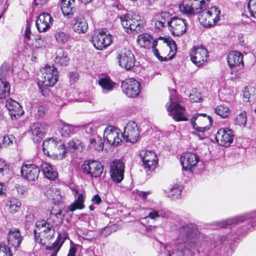

In [4]:
small_region = Image.open("./HIPT/HIPT_4K/image_demo/image_256.png")
small_region

In [ ]:
train_set.images[5]

## Define model

In [38]:
def compare_state_dicts(state_dict_1, state_dict_2):
    for key in state_dict_1.keys():
        if key in state_dict_2.keys():
            if not state_dict_1[key].shape == state_dict_2[key].shape:
                print(key)
                print(state_dict_1[key].shape, state_dict_2[key].shape)
        else:
            print(key)
        
def get_num_params(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(pytorch_total_params)

In [41]:
custom_vit = load_pretrained_vit()

Loding pretrained weights from ./HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth
Take key teacher in provided checkpoint dict
Pretrained weights found at ./HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=['pos_embed'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [3]:
# maybe adapt drop and drop attn
feature_extractor = get_vit()
feature_extractor.eval();
device = torch.device("cuda:0")

In [27]:
example = train_set.images[5]
transform = T.Compose([T.ToTensor()])
example = transform(example).to(device).unsqueeze(0)

In [ ]:
feature_extractor(example)

In [6]:

# load different pretrained model
# weights = ConvNeXt_Large_Weights.DEFAULT
# model = convnext_large(weights=weights)

# weights = ConvNeXt_Base_Weights.DEFAULT
# model = convnext_base(weights=weights)

weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)
return_nodes = {
    "flatten": "out",
    # "classifier.0": "out"
}

In [12]:
train_nodes, eval_nodes = get_graph_node_names(model)
train_nodes[-10::]

['features.6.14.block.1',
 'features.6.14.block.2',
 'features.6.14.block.3',
 'features.6.14.stochastic_depth',
 'features.6.14.add',
 'features.7',
 'avgpool',
 'flatten',
 'classifier.0',
 'classifier.1']

In [31]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# summary(model, input_size=(1, 3, 224, 224))

In [19]:
# return_nodes = ["classifier.1"]
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)
feature_extractor = FeatureExtractor(feature_extractor)

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")
feature_extractor.to(device);
feature_extractor.eval();
model_transforms = weights.transforms(antialias=True)

Using device: cuda:7


In [22]:
with torch.no_grad():
    for batch in train_loader:
        img, label = batch
        img = img.to(device)
        out = feature_extractor(img)

out.shape

torch.Size([62, 1280])

In [ ]:
classification_head = ClassificationHead(in_features=)

## Setup data

In [13]:
data_dir = "./data"
image_dir = f"{data_dir}/oxml-carinoma-classification"
image_paths, label_path = get_image_and_label_paths(image_dir)
image_paths[0:1], len(image_paths)

labels_df = pd.read_csv(label_path)
labels = labels_df["malignant"].tolist()
train_ids = labels_df["id"].tolist()
train_set_paths, test_set_paths = get_train_test_paths(image_paths, train_ids=train_ids)
len(train_set_paths), len(test_set_paths)

(62, 124)

Index([-1, 0, 1], dtype='int64', name='malignant')
Index(['negative', 'benign', 'malignant'], dtype='object')


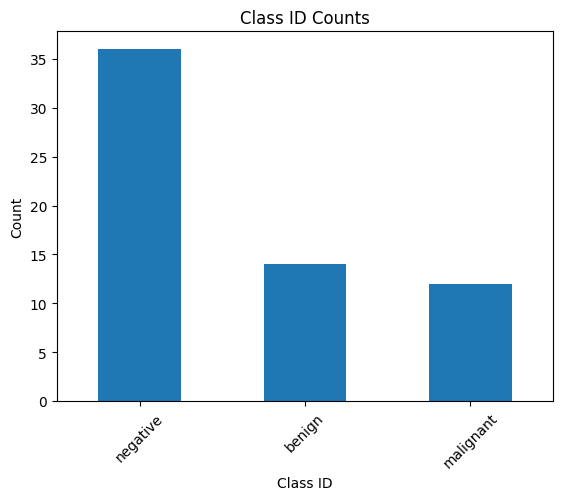

In [8]:
labels_df = pd.read_csv(label_path)
analyze_class_distribution(labels_df)

In [14]:
transforms = T.Compose(
    [
        # T.Resize((256, 256)),
        # T.CenterCrop(256),
        model_transforms,
    ]
)
train_set, train_loader, test_set, test_loader = prepare_train_test_data(
    image_paths,
    train_ids,
    labels,
    train_transforms=transforms,
    test_transforms=transforms,
    train_batch_size=64,
    test_batch_size=1024,
    num_workers=8,
    one_hot=False
)

In [11]:
# for k, img in enumerate(train_set):
#     print(k, img[0].shape)

## Extract features

In [16]:
X_train, y_train = extract_feature_sets(feature_extractor, train_loader, device=device)
X_test, y_test = extract_feature_sets(feature_extractor, test_loader, device=device)

X.shape: (62, 1536), y.shape: (62,)
X.shape: (124, 1536), y.shape: (124,)


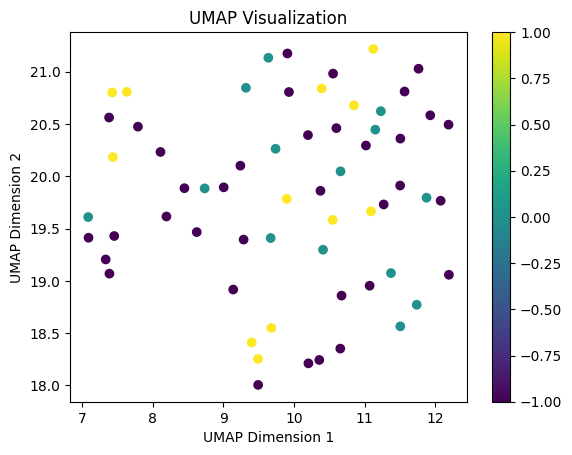

In [18]:
visualize_umap(X_train, y_train)

## Run Classifier

In [19]:
steps = [
    ("scaler", StandardScaler()),  # Example step for data scaling
    ("classifier", SVC(class_weight="balanced")),  # Example step for classification
]

# Create the pipeline
pipeline = Pipeline(steps)

In [20]:
y_train_pred, y_test_pred = run_sklearn_classifier(pipeline, X_train, y_train, X_test)

F1 scores: [0.69230769 0.61538462 0.41666667 0.58333333 0.66666667]
Mean F1 score: 0.5948717948717949
Train F1 score: 0.967741935483871


In [21]:
y_train_pred

array([-1, -1, -1,  0, -1, -1,  0, -1,  0, -1,  1, -1,  1,  1, -1, -1, -1,
       -1, -1, -1,  1, -1,  0, -1,  1, -1,  0, -1, -1,  0, -1, -1, -1, -1,
        0, -1,  1,  1,  0,  1, -1, -1, -1, -1,  1,  0,  0,  1, -1,  1,  0,
        0,  1,  0, -1, -1,  0,  1, -1, -1, -1,  1])

## Save submission

Index([-1, 1, 0], dtype='int64', name='malignant')
Index(['negative', 'malignant', 'benign'], dtype='object', name='malignant')


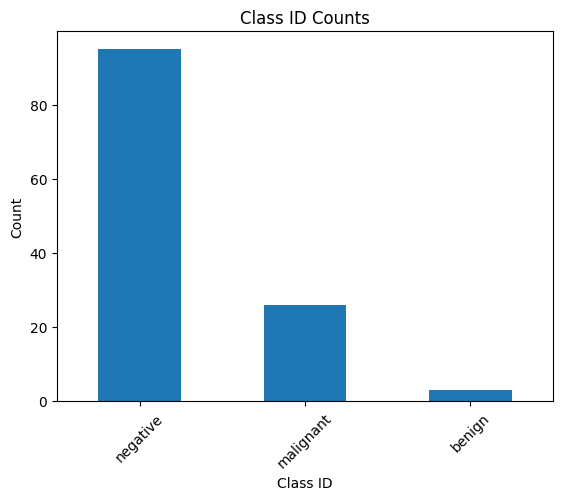

In [22]:
submission = create_submission_file(test_set_paths, y_test_pred)